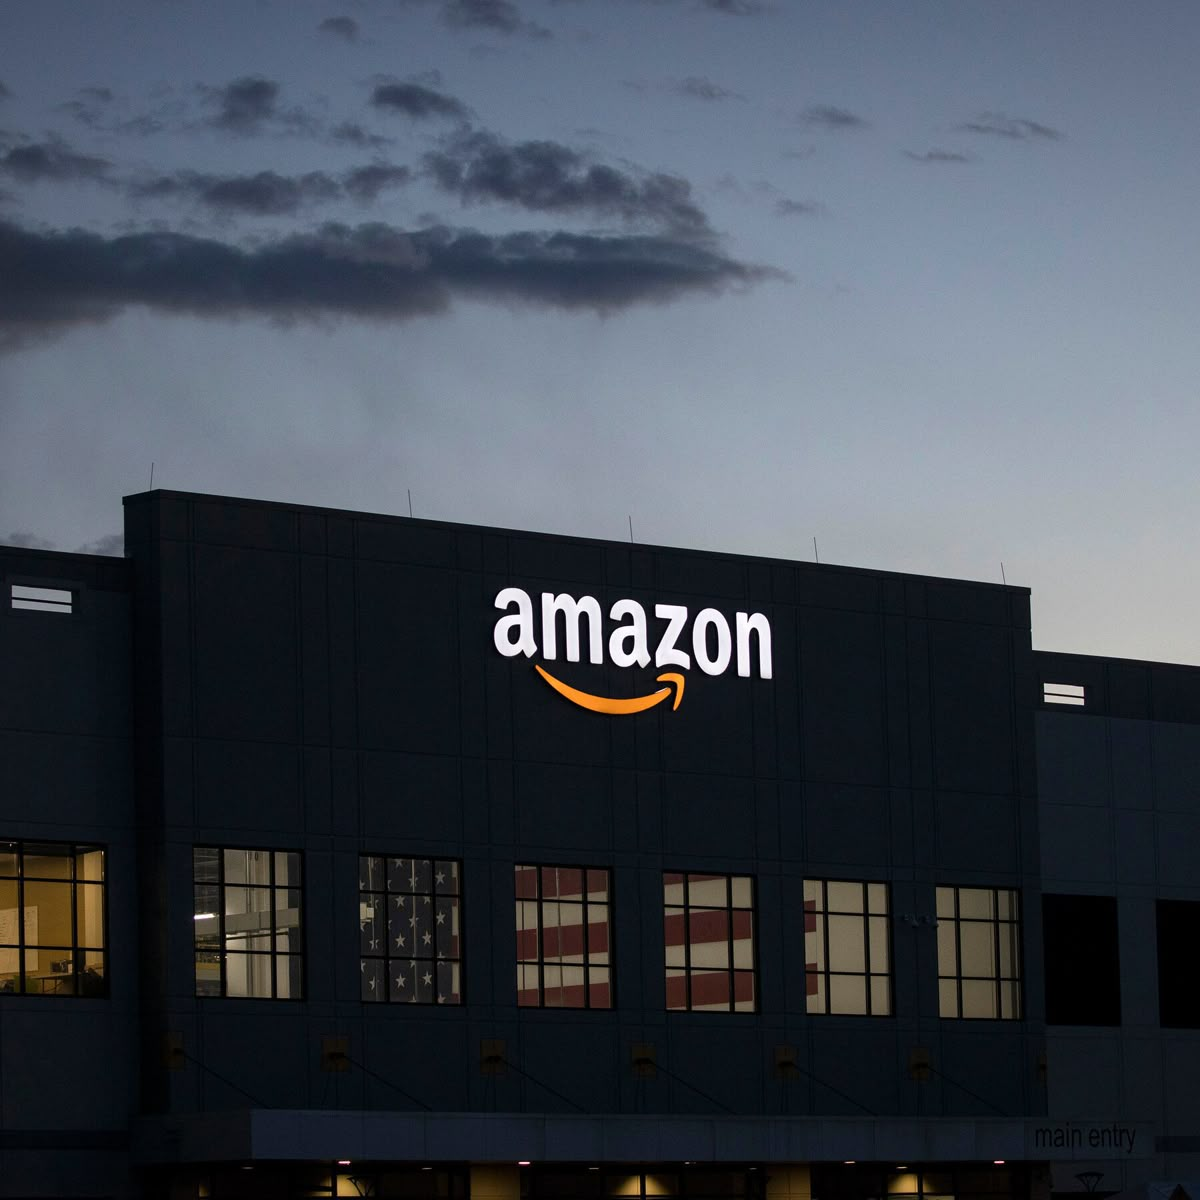

In this project, we harness natural language processing (NLP) and machine learning to classify customer reviews from Amazon products as positive or negative, uncovering insights into consumer sentiment.

In [24]:
# Libraries

import pandas as pd
import numpy as np
from zipfile import ZipFile as zp
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

- *Pandas and Numpy* for data handling (dataframes for reviews, arrays for numbers).
- *NLTK, Natural Language Toolkit* for preprocessing (stopwords like "the", "is", stemming to reduce words like "running" -> "run").
- *Scikit-learn* ia a ML library. Handles splitting data, vectorizing text, models, and metrics.
- *Matplotlib and Seaborn* for plots (e.g., confusion matrix).
- *WordCloud* generates visual word clouds for frequent terms.

***Note:** why NLTK over SpaCy? NLTK is lighter and great for beginners, however SpaCy is faster for large-scale but overkill here.*

In [17]:
data = pd.read_csv("/content/7817_1.csv")
data_copy = data.copy()

# Handle nested if present (parse and explode to one review per row)
if isinstance(data['reviews.text'].iloc[0], str) and data['reviews.text'].str.contains(r'\[.*\]').any():

    # Parse stringified lists
    data['reviews.text'] = data['reviews.text'].apply(lambda x: eval(x) if isinstance(x, str) else [x] if pd.notna(x) else [])
    data['reviews.rating'] = data['reviews.rating'].apply(lambda x: eval(x) if isinstance(x, str) else [x] if pd.notna(x) else [])

    # Create DataFrame with one row per review
    exploded_data = pd.DataFrame({
        'reviews.text': [item for sublist in data['reviews.text'] for item in sublist],
        'reviews.rating': [item for sublist in data['reviews.rating'] for item in sublist],
        'name': np.repeat(data['name'].values, data['reviews.text'].apply(len).values)})

    df = exploded_data.dropna(subset = ['reviews.text', 'reviews.rating'])

else: print(f"Shape: {data.shape}")

Shape: (1597, 27)


In [19]:
# Binarization
# Positive (1) if Score >=4, else Negative (0)

data['Sentiment'] = (data['reviews.rating'] >= 4).astype(int)

In [20]:
# Select relevant columns (focus on reviews)

data = data[['reviews.text', 'Sentiment', 'reviews.rating']].copy()
data.dropna(subset = ['reviews.text'], inplace = True)  # Drop empty reviews
data['reviews.text'] = data['reviews.text'].astype(str)

In [21]:
# Basic exploration
print("Final dataset shape:", data.shape)
print("----------------------------------")
print("\nClass distribution:\n", data['Sentiment'].value_counts())
print("----------------------------------")
print(f"\nSample reviews: \n{data.head()}")

Final dataset shape: (1597, 3)
----------------------------------

Class distribution:
 Sentiment
1    977
0    620
Name: count, dtype: int64
----------------------------------

Sample reviews: 
                                        reviews.text  Sentiment  \
0  I initially had trouble deciding between the p...          1   
1  Allow me to preface this with a little history...          1   
2  I am enjoying it so far. Great for reading. Ha...          1   
3  I bought one of the first Paperwhites and have...          1   
4  I have to say upfront - I don't like coroporat...          1   

   reviews.rating  
0             5.0  
1             5.0  
2             4.0  
3             5.0  
4             5.0  


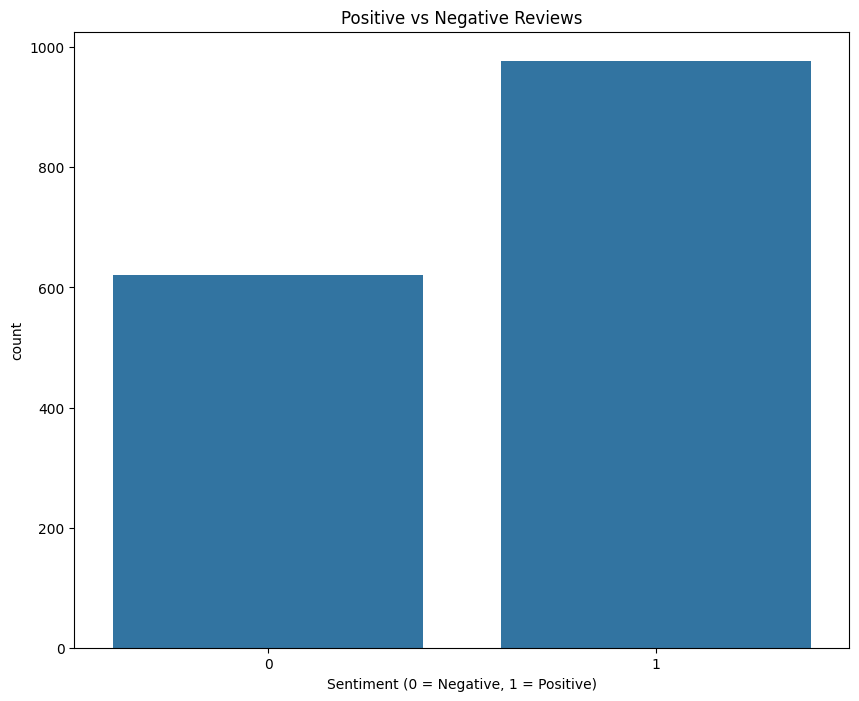

In [22]:
# Visualize class balance
plt.figure(figsize = (10, 8))
sns.countplot(x = 'Sentiment', data = data)
plt.title('Positive vs Negative Reviews')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.show()

In [25]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags = re.MULTILINE)

    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize (split into words)
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and stem
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

sample = data['reviews.text'].iloc[0]
print("Original:", sample[ : 100] + "...")
print("Processed:", preprocess_text(sample) + "...")

# Apply
data['Processed_Text'] = data['reviews.text'].apply(preprocess_text)
print("\nPreview:\n", data[['Processed_Text', 'Sentiment']].head())

Original: I initially had trouble deciding between the paperwhite and the voyage because reviews more or less ...
Processed: initi troubl decid paperwhit voyag review less said thing paperwhit great spend money voyagefortun friend own end buy paperwhit basi model ppi dollar jump turn pricey voyag page press isnt alway sensit fine specif set dont need auto light adjustmentit week love paperwhit regret touch screen recept easi use keep light specif set regardless time day case hard chang set either youll chang light level certain time day everi readingalso glad went intern ship option amazon extra expens deliveri time track didnt need worri custom may use third parti ship servic...

Preview:
                                       Processed_Text  Sentiment
0  initi troubl decid paperwhit voyag review less...          1
1  allow prefac littl histori casual reader own n...          1
2  enjoy far great read origin fire sinc fire use...          1
3  bought one first paperwhit pleas constant

Basically, *re.sub()* uses regex for cleaning, and *word_tokenize()* splits words. Stemmer reduces

In [26]:
# Splitting data

x = data['Processed_Text']
y = data['Sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

# TF-IDF

vectorizer = TfidfVectorizer(max_features = 3000, ngram_range = (1, 2), min_df = 2)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

print("TF-IDF shape:", x_train_tfidf.shape)
print("Sample features:", vectorizer.get_feature_names_out()[ : 10])

TF-IDF shape: (1277, 3000)
Sample features: ['abil' 'abl' 'abl compar' 'abl hear' 'abl play' 'abl see' 'abl use'
 'abl watch' 'absolut' 'absolut amaz']


* Why *stratify = y*?

Stratification refers to a method used during data splitting (e.g., in train-test splits or cross-validation) to ensure that the proportion of classes in the target variable is preserved across all subsets. In the context of our dataset for fraud detection, where the target variable "Class" is highly imbalanced (approximately 0.17% fraud cases, Class=1, and 99.83% non-fraud cases, Class=0), stratification plays a crucial role to maintain representative class distributions in both training and test sets.

In fact, without stratification, random splitting could result in subsets with disproportionate class ratios, such as a training set with few or no fraud cases, leading to poor model learning, or a test set with an unrealistic number of frauds, yielding misleading performance metrics (e.g., precision, recall, F1 score). For that reason, it ensures that each subset reflects the original dataset’s class distribution, enabling the model (e.g., XGBoost in your project) to train effectively on fraud patterns and providing reliable evaluation metrics for imbalanced data.

In a nutshell, stratification ensures that both training and testing sets have the same class proportions as the original dataset — which is crucial for imbalanced datasets like fraud detection.

In this snippet, we first define x as the processed text features and y as binary sentiment labels, setting up inputs for supervised learning where text clues map to positive/negative outcomes. Next, train_test_split divides the data 80/20 with stratify = y to maintain class balance and random_state = 0 for reproducibility, preventing overfitting by training on one subset and testing on unseen data.

 The TfidfVectorizer then converts text to numerical matrices, fit_transform on training learns vocabulary and weights (TF-IDF scores emphasizing rare, informative terms like "disappointing"), while transform applies it to test data without leakage. Parameters like max_features = 3000 curb dimensionality, ngram_range = (1, 2) captures phrases for context (e.g., "not good"), and min_df = 2 drops rare noise.

 Finally, prints verify the sparse matrix shape and sample terms, ensuring everything's ready for modeling.

Logistic Regression:
Accuracy: 0.78
Precision: 0.89
Recall: 0.72
F1-Score: 0.80

Report:
               precision    recall  f1-score   support

           0       0.66      0.86      0.75       124
           1       0.89      0.72      0.80       196

    accuracy                           0.78       320
   macro avg       0.78      0.79      0.77       320
weighted avg       0.80      0.78      0.78       320



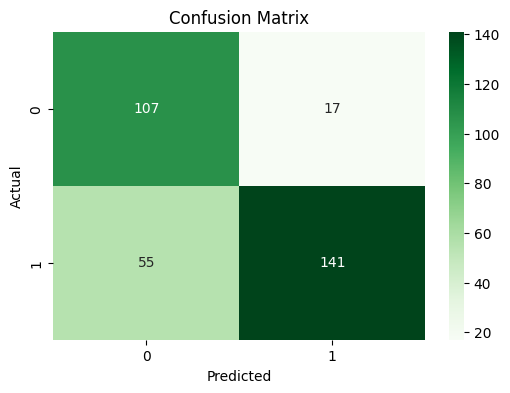

In [28]:
model = LogisticRegression(random_state = 42, max_iter = 1000, class_weight = 'balanced')
model.fit(x_train_tfidf, y_train)
pred = model.predict(x_test_tfidf)

# Metrics
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print("Logistic Regression:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification Reports
print("\nReport:\n", classification_report(y_test, pred))

# Confusion Matrix
cm = confusion_matrix(y_test, pred)
plt.figure(figsize = (6,4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

This code trains a Logistic Regression model on TF-IDF features (x_train_tfidf) with balanced class weights to handle imbalance, fitting via model.fit() to learn word-sentiment probabilities, then predicts on test data (pred = model.predict(x_test_tfidf)).

Furthermore, metrics like accuracy (overall correct predictions), precision (89% true-low false positives), recall (caught 72% of true positives-missed some negatives), and F1 (balanced precision/recall) evaluate performance, with the report breaking it per class (stronger on positives due to more support: 196 vs. 124 negatives). The confusion matrix heatmap visualizes errors (e.g., high true negatives but some false negatives), using seaborn for clarity.

Overall, 78% accuracy is solid for imbalanced text data, but low negative recall (66% precision) suggests tweaks like more features or oversampling.

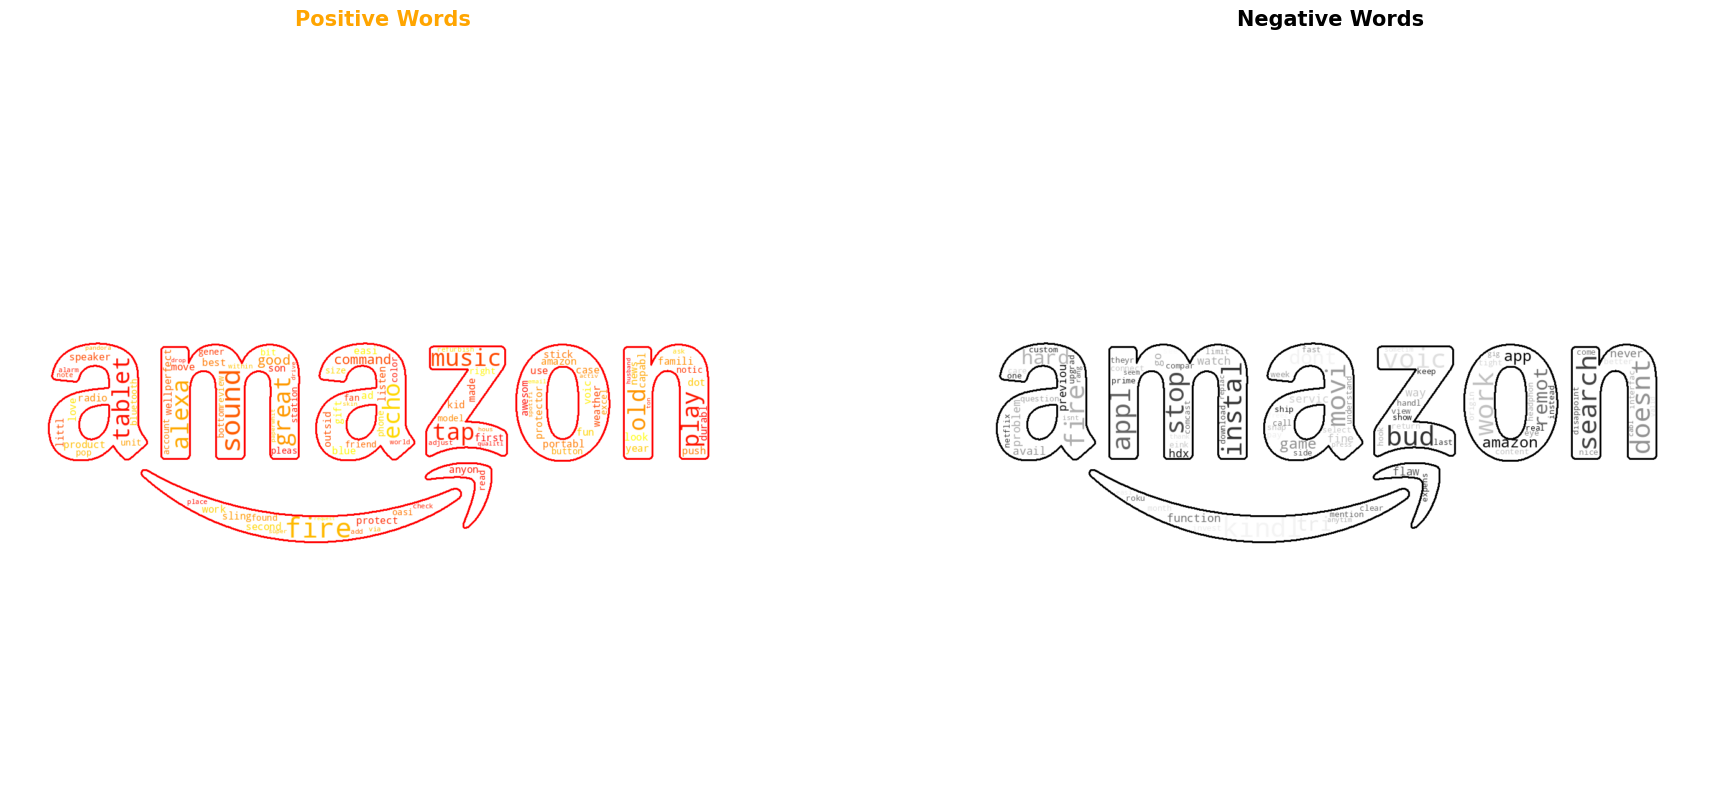

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def get_top_words(model, vectorizer, class_label, n = 100):
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_[0]
    if class_label == 1: top_indices = np.argsort(coef)[-n : ][ : : -1]
    else: top_indices = np.argsort(coef)[ : n]
    return [feature_names[i] for i in top_indices]

# Adding logo, and convert it into grayscale
mask = np.array(Image.open("/content/dataset-card.png"))
mask = np.where(mask > 128, 255, 0).astype(np.uint8)
mask = 255 - mask

# Pos/Neg words
positive_words = get_top_words(model, vectorizer, 1, 100)
negative_words = get_top_words(model, vectorizer, 0, 100)

# Positive words
positive_text = ' '.join(positive_words)
wordcloud_pos = WordCloud(
    width = 800, height = 400, background_color = 'white', mask = mask,
    colormap = 'autumn', contour_color = 'red', contour_width = 2).generate(positive_text)

# Negative words
negative_text = ' '.join(negative_words)
wordcloud_neg = WordCloud(
    width = 800, height = 400, background_color = 'white', mask = mask,
    colormap = 'gray', contour_color = 'black', contour_width = 2).generate(negative_text)

fig, axes = plt.subplots(1, 2, figsize = (20, 8))

axes[0].imshow(wordcloud_pos, interpolation = 'bilinear')
axes[0].set_title('Positive Words', fontsize = 15, color = 'orange', fontweight = 'bold')
axes[0].axis('off')

axes[1].imshow(wordcloud_neg, interpolation = 'bilinear')
axes[1].set_title('Negative Words', fontsize = 15, color = 'black', fontweight = 'bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()


This code enhances word cloud visualization by extracting top influential words per class using get_top_words, sorting model coefficients (coef_[0]) to rank features (highest for positives, lowest for negatives via np.argsort). It loads a mask and converted to binary grayscale for shaping clouds like a logo, then generates shaped clouds, positive with autumn colormap and red contours, negative with gray and black, both masked for visual appeal. Words are joined into strings and fed to WordCloud.generate, emphasizing model interpretability (e.g., "love" big in positives). Subplots display them side-by-side with styled titles, using plt.tight_layout for clean layout and interpolation='bilinear' for smooth rendering.

As a result, engaging visuals revealing sentiment drivers-tune n = 100 for more words or swap masks for fun.

In [ ]:
# Finally

***I WOULD LIKE TO EXPRESS MY SINCERE GRATITUDE FOR YOUR TIME AND CONSIDERATION***

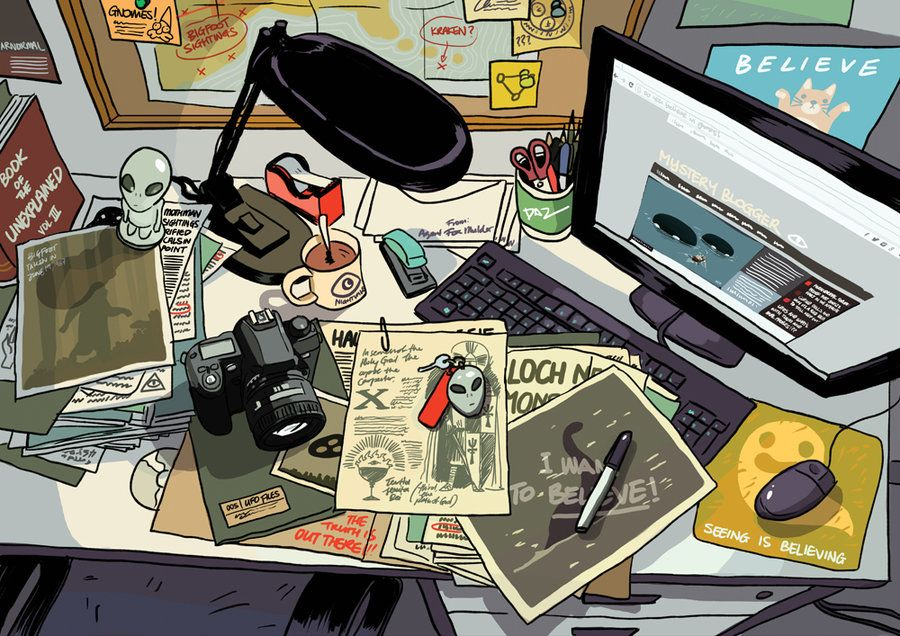